# Inspiration
**Scenario 1**: Someone gives us a single piece of text and asks us to rate its readability on a scale of -3 to 3  
**Scenario 2**: Someone gives us two piece of texts and asks us to which one is easier to read

**Scenario 1** corresponds to training a Neural network based on RMSE loss  
**Scenario 2** corresponds to training a Neural network based on Ranking Loss

Essentially once can see this task as a Ranking task where in we rank the text excerpts based on ease of reading. I personally feel its more intuitive to for the network to learn the parameters while comparing two pieces of texts. In that way the network can more directly learn weight parameters that are contrastive enough to learn discriminatory features. 

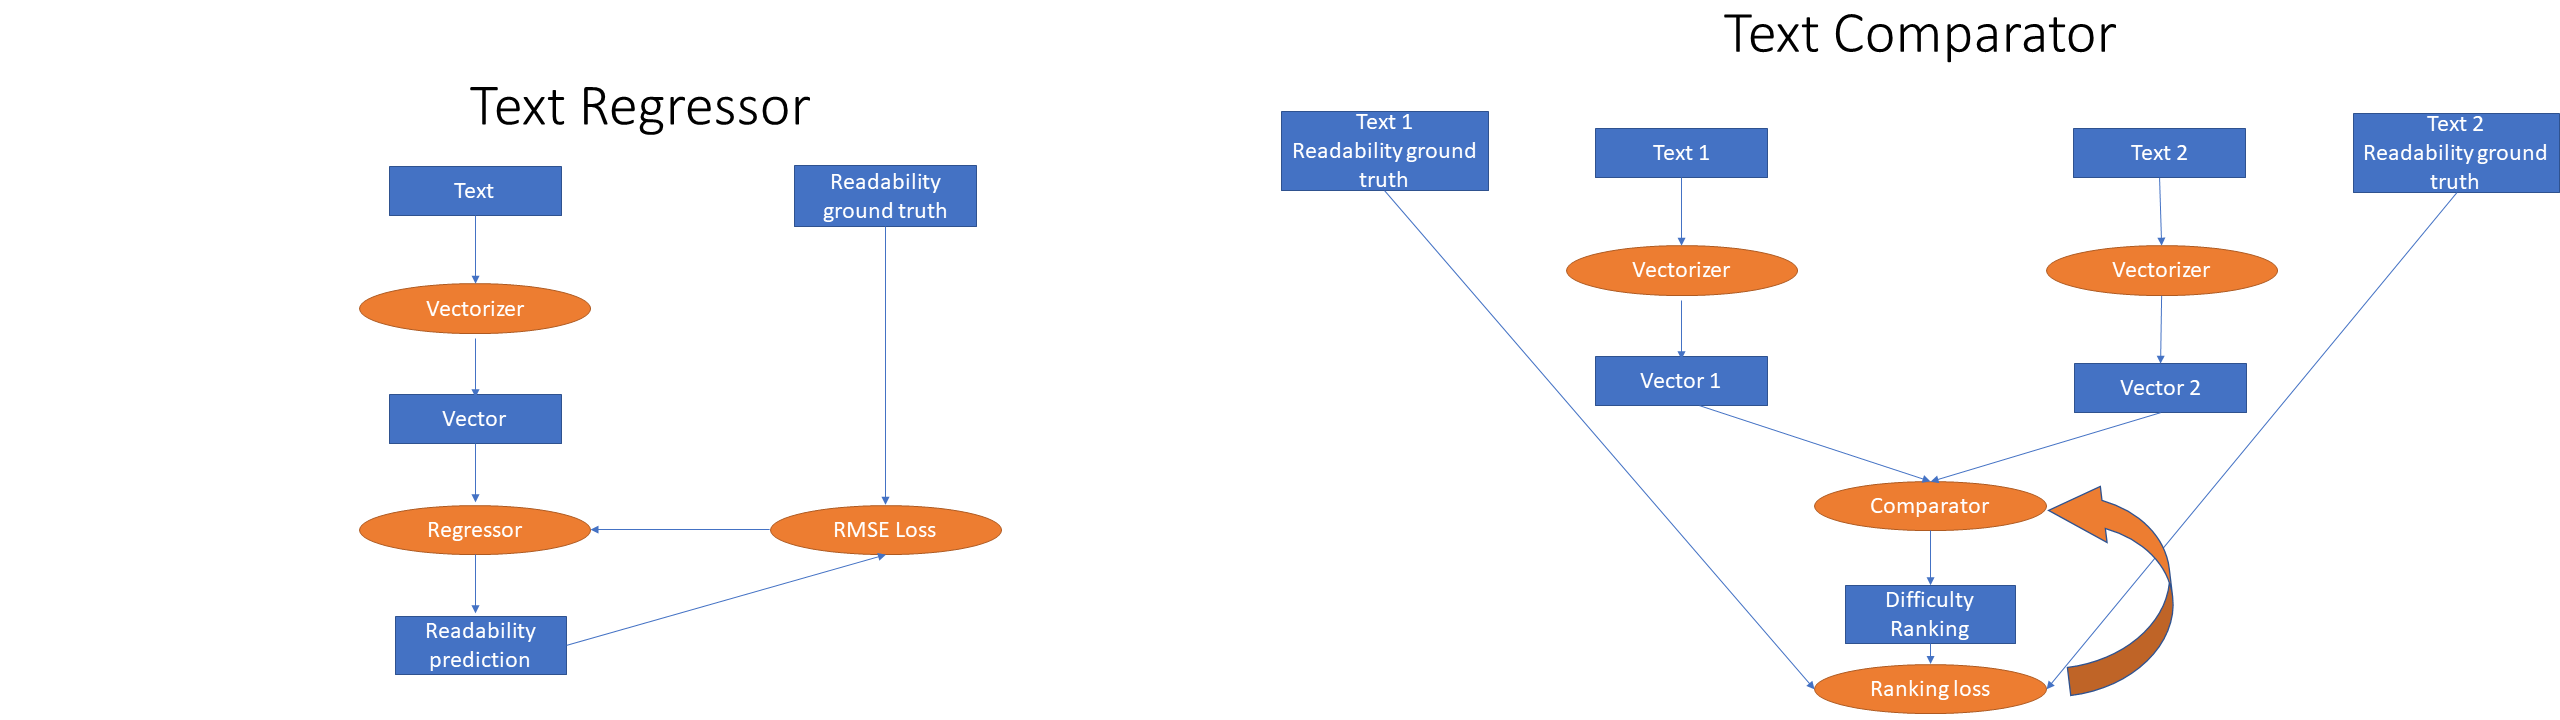

In [ ]:
import torch
import spacy
import numpy as np
import pandas as pd
import plotly.express as px

from torch import nn
from pathlib import Path
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [ ]:
BATCH_SIZE = 64
RANDOM_STATE = 41
FEATURES_SIZE = 300
nlp = spacy.load('en_core_web_lg')

In [ ]:
COMPETITION_DATA_PATH = Path('../input/commonlitreadabilityprize')
TRAIN_DATA_PATH = COMPETITION_DATA_PATH / 'train.csv'
TEST_DATA_PATH =  COMPETITION_DATA_PATH / 'test.csv'

In [ ]:
train_data = pd.read_csv(TRAIN_DATA_PATH)
# Remove this for submission
# train_data = train_data.sample(frac=0.05)
test_data = pd.read_csv(TEST_DATA_PATH)
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=RANDOM_STATE)

print(f'Length of train data: {len(train_data)}')
print(f'Length of valid data: {len(valid_data)}')
print(f'Length of test data : {len(test_data)} ')

# Spacy Feature extraction
All Credits to Sumit Kumar @anaverageengineer https://www.kaggle.com/anaverageengineer/comlrp-baseline-for-complete-beginners

In [ ]:
def create_features(text_excerpts):
    with nlp.disable_pipes():
        features = np.vstack([nlp(text).vector for text in text_excerpts])
    return features

def create_targets(targets):
    targets = targets.reshape(-1, 1).astype(np.float32)
    return targets

In [ ]:
CREATE_AND_SAVE_INPUTS = True
if CREATE_AND_SAVE_INPUTS:
    X_train = create_features(train_data['excerpt'].tolist())
    y_train = create_targets(train_data['target'].to_numpy())
    X_valid = create_features(valid_data['excerpt'].tolist())
    y_valid = create_targets(valid_data['target'].to_numpy())
    # Variables -> File
    with open('spacy_features_targets.npy', 'wb') as f:
        np.savez(f, X_train=X_train, y_train=y_train, X_valid=X_valid, y_valid=y_valid)
else:
    with open('spacy_features_targets.npy', 'rb') as f:
        spacy_features_targets = np.load(f)
        # File -> Variables
        X_train = spacy_features_targets['X_train']
        X_valid = spacy_features_targets['X_valid']
        y_train = spacy_features_targets['y_train']
        y_valid = spacy_features_targets['y_valid']

# Datasets and Dataloaders definition

In [ ]:
class TrainingDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]
    
class PredictionDataset(Dataset):
    def __init__(self, text_excerpts):
        self.text_excerpts = text_excerpts
    
    def __len__(self):
        return len(self.text_excerpts)
    
    def __getitem__(self, idx):
        text = self.text_excerpts[idx]
        with nlp.disable_pipes():
            features = nlp(text).vector
        return features

# Model definition

In [ ]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear = nn.Sequential(
            nn.Linear(FEATURES_SIZE, FEATURES_SIZE),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(FEATURES_SIZE, 1)
        )
    def forward(self, x):
        x = self.linear(x)
        return x

# Create datasets and dataloaders

In [ ]:
train_dataset = TrainingDataset(features=X_train, targets=y_train)
valid_dataset = TrainingDataset(features=X_valid, targets=y_valid)
test_dataset = PredictionDataset(text_excerpts=test_data['excerpt'].tolist())

train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Earlystopping

In [ ]:
class EarlyStopping:
    def __init__(self, patient_epochs=2):
        self.best_valid_loss = np.inf
        self.best_epoch = -1
        self.patient_epochs = patient_epochs
    
    def should_stop(self, current_epoch, current_valid_loss):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            self.best_epoch = current_epoch
        return True if current_epoch > self.best_epoch + self.patient_epochs else False

# Training and evaluation loop

In [ ]:
def train_one_epoch(dataloader, model, optimizer, loss_fn):
    model.train()
    total_loss = 0
    for batch_num, (X, y) in enumerate(dataloader):
        # Forward pass
        y_pred = model(X)
        if str(loss_fn)=='MarginRankingLoss()':
            y_shuffled, y_pred_shuffled = shuffle(y, y_pred)
            y_comparison = (y - y_shuffled).sign()
            loss = loss_fn(y_pred, y_pred_shuffled, y_comparison)
        if str(loss_fn)=='MSELoss()':
            loss = loss_fn(y_pred, y)
        total_loss += loss.item()
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    average_loss = total_loss / (batch_num + 1)
    return average_loss

def validate_one_epoch(dataloader, model, loss_fn):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch_num, (X, y) in enumerate(dataloader):
            # Forward pass
            y_pred = model(X)
            if str(loss_fn)=='MarginRankingLoss()':
                y_shuffled, y_pred_shuffled = shuffle(y, y_pred)
                y_comparison = (y - y_shuffled).sign()
                loss = loss_fn(y_pred, y_pred_shuffled, y_comparison)
            if str(loss_fn)=='MSELoss()':
                loss = loss_fn(y_pred, y)
            total_loss += loss.item()
    average_loss = total_loss / (batch_num + 1)
    return average_loss

def predict(dataloader, model):
    model.eval()
    with torch.no_grad():
        y_preds = []
        for batch_num, X in enumerate(dataloader):
            y_pred = model(X)
            y_preds.append(y_pred.cpu().detach().numpy())
    y_preds = np.vstack(y_preds)
    return y_preds

# MarginRankingLoss

In [ ]:
model = Model()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.005, momentum=0.9, nesterov=True)
early_stopping = EarlyStopping(patient_epochs=50)
loss_fn = nn.MarginRankingLoss(margin=0.5)

for epoch in range(1000):
    train_loss = train_one_epoch(train_dataloader, model, optimizer, loss_fn)
    valid_loss = validate_one_epoch(valid_dataloader, model, loss_fn)
    if early_stopping.should_stop(current_epoch=epoch, current_valid_loss=valid_loss):
        print(f'Exiting At epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}')
        break
    if epoch % 10 == 0:
        print(f'Training loss at epoch {epoch} is {train_loss: .6f}')
        print(f'Validation loss at epoch {epoch} is {valid_loss: .6f}')
        
valid_prediction_dataset = PredictionDataset(text_excerpts=valid_data['excerpt'].tolist())
valid_prediction_dataloader = DataLoader(dataset=valid_prediction_dataset, batch_size=BATCH_SIZE, shuffle=False)
y_valid_pred = predict(valid_prediction_dataloader, model)
valid_data_pred_df = pd.DataFrame.from_dict({'pred': y_valid_pred.reshape(-1), 'target': valid_data['target'].to_numpy()})
fig = px.scatter(valid_data_pred_df, x="pred", y="target", trendline="ols", title="Margin Ranking loss")
fig.show()

In [ ]:
regressor = Ridge().fit(valid_data_pred_df['pred'].to_numpy().reshape(-1, 1), valid_data_pred_df['target'].to_numpy().reshape(-1, 1))
test_data['target'] = regressor.predict(predict(test_dataloader, model))
test_data[['id','target']].to_csv('submission.csv', index=False)

# MSELoss

In [ ]:
model = Model()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.005, momentum=0.9, nesterov=True)
early_stopping = EarlyStopping(patient_epochs=50)
loss_fn = nn.MSELoss()

for epoch in range(1000):
    train_loss = train_one_epoch(train_dataloader, model, optimizer, loss_fn)
    valid_loss = validate_one_epoch(valid_dataloader, model, loss_fn)
    if early_stopping.should_stop(current_epoch=epoch, current_valid_loss=valid_loss):
        print(f'Exiting At epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}')
        break
    if epoch % 10 == 0:
        print(f'Training loss at epoch {epoch} is {train_loss: .6f}')
        print(f'Validation loss at epoch {epoch} is {valid_loss: .6f}')
        
valid_prediction_dataset = PredictionDataset(text_excerpts=valid_data['excerpt'].tolist())
valid_prediction_dataloader = DataLoader(dataset=valid_prediction_dataset, batch_size=BATCH_SIZE, shuffle=False)
y_valid_pred = predict(valid_prediction_dataloader, model)
valid_data_pred_df = pd.DataFrame.from_dict({'pred': y_valid_pred.reshape(-1), 'target': valid_data['target'].to_numpy()})
fig = px.scatter(valid_data_pred_df, x="pred", y="target", trendline="ols", title="RMSE loss")
fig.show()

# Inference
Althought the correlation of predictions and targets are similar for both the losses, MarginRankingLoss provides the advantage of adding external data for pretraining the model very easily. For instance we know that text from Simple Wikipedia is easier in comparison to Wikipedia. We know that lessons of grade 8 text are easier comparison to grade 12. So finally we can scrape and add a lot of external data and pretrain the network for achieving better performance.

Thank you for reading!